In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
from skimage.transform import rescale, resize

## Load Data

In [2]:
img_list = np.load('test_npy/7-12-17-preprocessed.npy')

print('Image size: ', img_list.shape[1])

Image size:  203


## Resize Image

In [3]:
re_list = []
for i in range(len(img_list)):
    img_re = resize(img_list[i], (200, 200), anti_aliasing=False)
    re_list.append(img_re)
    
re_list = np.asarray(re_list)

IMG_SIZE = re_list.shape[1]
print('New image size: ', IMG_SIZE)

/home/kevinteng/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


New image size:  200


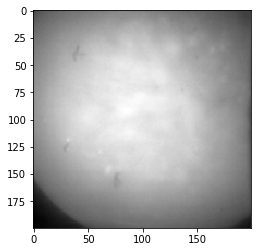

In [4]:
for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    break
    
#     if input()=='exit':
#         break

In [5]:
print(np.min(re_list[0]))
print(np.max(re_list[0]))

0.1490782107843141
0.7914949264705882


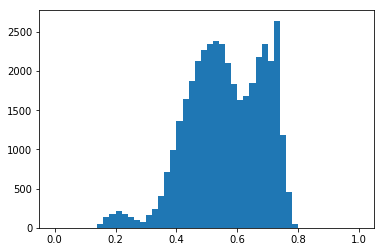

In [6]:
#plot historgram 
plt.hist(re_list[0].ravel(),50,[0,1])
plt.show()

In [7]:
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)

#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

In [8]:
BATCH_SIZE = 32
MAX_STEP = 5000
REPEAT = 20
lr = 1e-3

ds_train = tf.data.Dataset.from_tensor_slices(re_list).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1

def conv_block(x_in, filters, kernel_size, strides, padding, activation, 
               batch_norm = False, max_pool = False):
    
    x = Conv2D(filters, kernel_size, strides, padding, kernel_regularizer = l1(0.01))(x_in)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    if max_pool:
        assert strides < 2 or strides < (2,2), "Downsampling too fast for strides greater than 2"
        
        x = MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same')(x)
        
    return x 

def up_block(x_in, up_size, filters, kernel_size, strides, padding, activation,
             batch_norm = False):
    
    u = UpSampling2D(up_size)(x_in)
    #by default during upsampling Conv2D does not need maxpooling!
    conv_u = conv_block(u, filters, kernel_size, strides, padding, activation, batch_norm)
    return conv_u

def encoder(input_layer,coordconv = False, dense_out = False):
    if coordconv:
        conv_01 = CoordConv(x_dim = IMG_SIZE, y_dim = IMG_SIZE, with_r = False, filters = 32, 
              kernel_size = 1, padding='same', activation='relu')(input_layer)
    else:
        conv_01 = conv_block(input_layer, filters = 32, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True)
    
    conv_02 = conv_block(conv_01, filters = 48,kernel_size = 3, strides = 1, 
                         padding = 'same',  activation = 'relu', batch_norm = True, max_pool = True)
    conv_03 = conv_block(conv_02, filters = 64,kernel_size = 3, strides = 1, 
                         padding = 'same',  activation = 'relu', batch_norm = True, max_pool = True)
    
    if dense_out:
        flat_01 = Flatten()(conv_03)
        dense_01 = Dense(latent_dim)(flat_01)
        
        return dense_01 
    else:
        conv_04 = conv_block(conv_03, filters = 80,kernel_size = 3, strides = 2, 
                         padding = 'same', activation = 'linear')
        return conv_04
    
def decoder(input_latent, kernel_regularizer = None, dense_out = False):
    #by default, batch_norm is off in decoder
    
    if dense_out:
        #assert tf.rank(input_latent) == 2, "Input not from Dense layer!"
        
        dense_02 = Dense(50*50*64, activation = 'relu')(input_latent)
        up_01 = Reshape((50,50,64))(dense_02)
    
    else:
        up_01 = up_block(input_latent, up_size = 2, filters = 64, kernel_size = 3,
                        strides = 1, padding = 'same', activation = 'relu')
        
    up_02 = up_block(up_01, up_size = 2, filters = 48, kernel_size = 3,
                    strides = 1, padding = 'same', activation = 'relu')
    
    up_03 = up_block(up_02, up_size = 2, filters = 32, kernel_size = 3,
                    strides = 1, padding = 'same', activation = 'relu')
    
    output = conv_block(up_03, filters = 1, kernel_size = 3, strides = 1, 
                        padding = 'same', activation = 'sigmoid')
    return output

----------------------------

In [10]:
#High level api

latent_dim = 10
input_layer = Input(shape = (200, 200, 1))

encoder_net = encoder(input_layer, coordconv = True, dense_out = True)
decoder_net = decoder(encoder_net, dense_out = True)
Autoencoder = Model(input_layer, decoder_net)

In [13]:
opt = tf.optimizers.Adam(1e-3)

Autoencoder.compile(optimizer = opt, loss = 'mean_squared_error')
Autoencoder.fit(re_list, re_list, epochs=50, batch_size= BATCH_SIZE, verbose=1, shuffle=True) #no validation data 

Epoch 1/50
605/605 [==============================] - 5s 8ms/sample - loss: 27.2706
Epoch 2/50
605/605 [==============================] - 3s 4ms/sample - loss: 15.2963
Epoch 3/50
605/605 [==============================] - 3s 4ms/sample - loss: 6.9245
Epoch 4/50
605/605 [==============================] - 3s 4ms/sample - loss: 2.1361
Epoch 5/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.5643
Epoch 6/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.2273
Epoch 7/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.1380
Epoch 8/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.1158
Epoch 9/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.1096
Epoch 10/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.1075
Epoch 11/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.1062
Epoch 12/50
605/605 [==============================] - 3s 4ms/sample - loss: 0.1050

-------------------------------------------------

## Helper Function

In [14]:
def plot_2(ori_imgs, recon_imgs, figsize = (5, 5)):
    '''
    Plot comparison of one original and one reconstructed image
    '''
    print()
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(np.reshape(ori_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[0].set_xlabel('Original Image')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[1].set_xlabel('Reconstructed Image')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
        

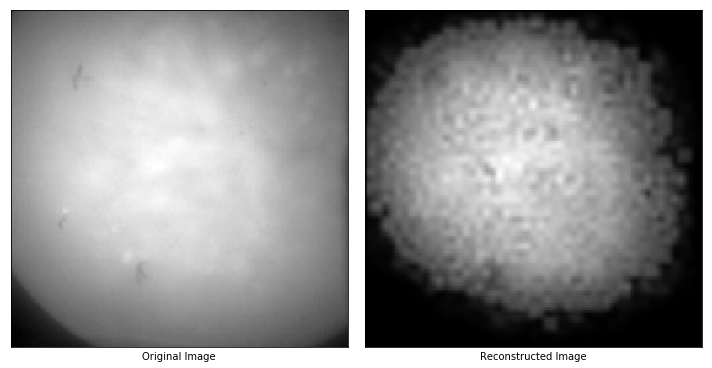

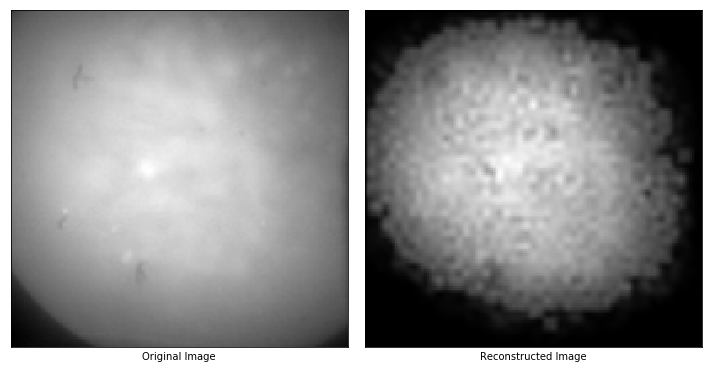

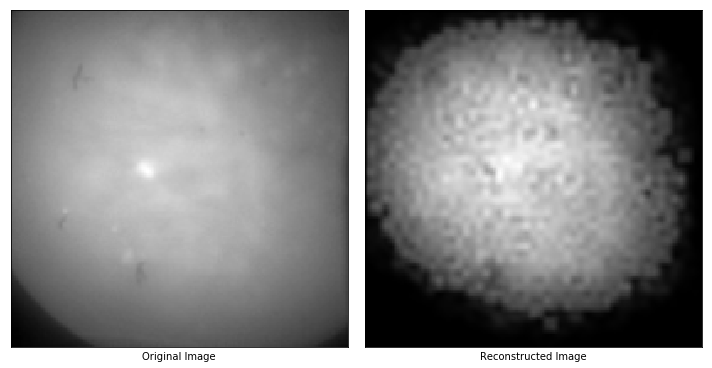

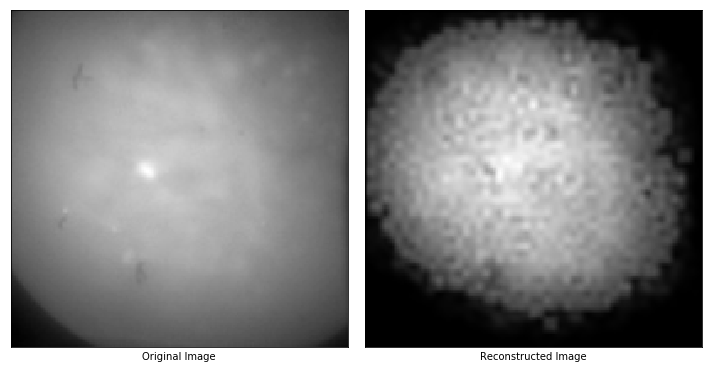

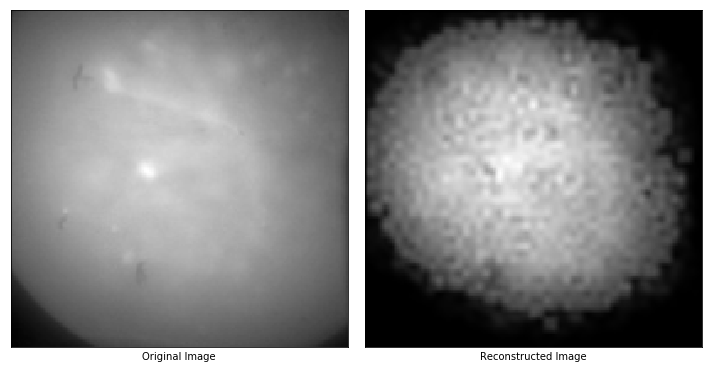

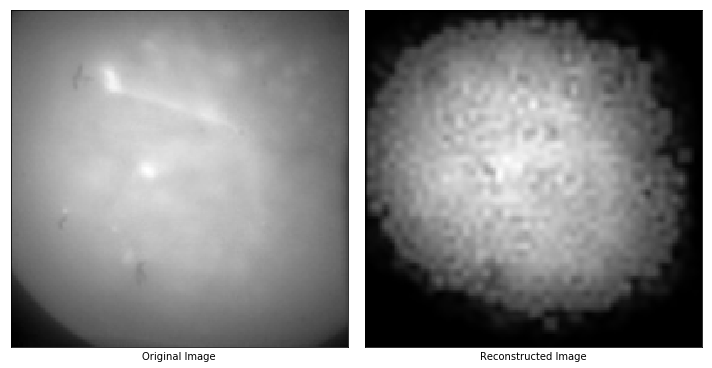

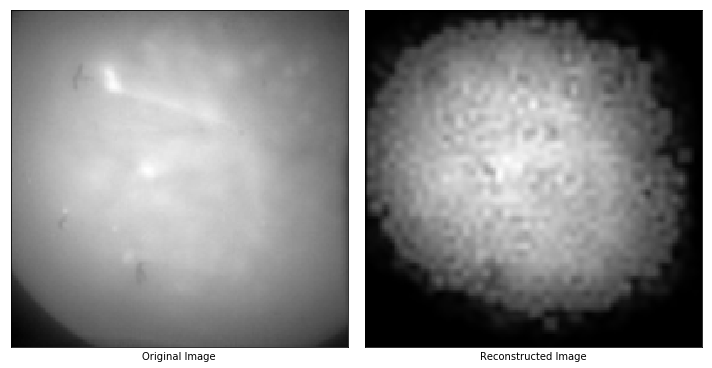

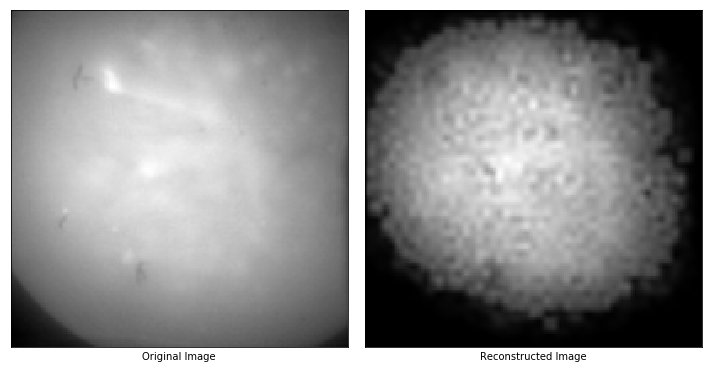

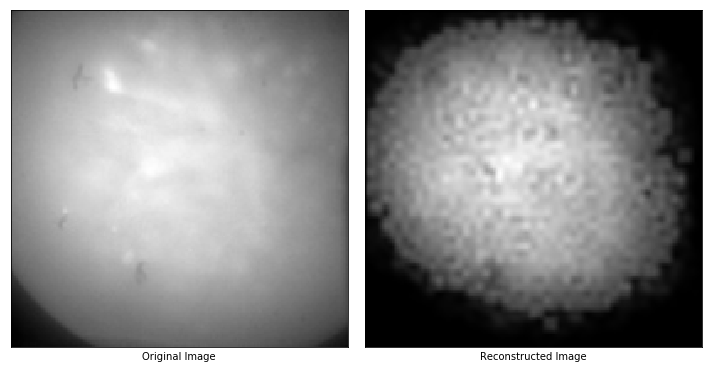

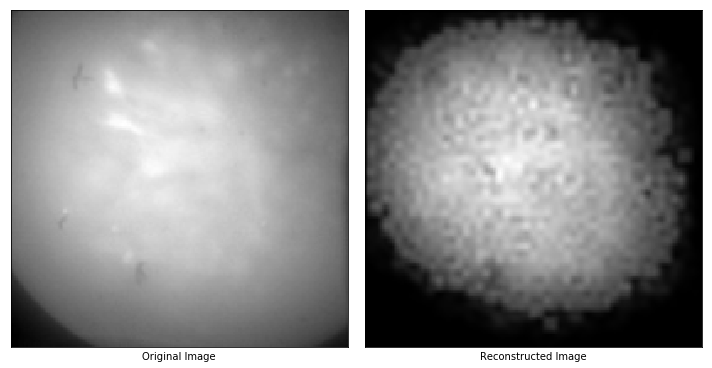

In [15]:
recon_img = Autoencoder.predict(re_list)
n = 10
n_max = len(recon_img)

for i in range(n):
    plot_2(re_list[i], recon_img[i], figsize = (10,10))

In [16]:
def layers_dict( model):
    '''
    :param model: deep learning model

    :return:
        Dictionary with 'key': layer names, value: layer information
    '''
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    return layer_dict

def feature_maps(model, layer_name, inps):
    '''
    This function visualize the intermediate activations of the filters within the layers
    :param model: deep learning model
    :param layer_name: desired layer name, if forgotten, please refer to layers_dict function
    :param inps: feed the network with input, such as images, etc. input dimension
                 should be 4.

    :return:
        feature maps of the layer specified by layer name,
        with dimension ( batch, row size, column size, channels)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"
    #retrieve key value from layers_dict
    layer_dict = layers_dict(model)

    #layer output with respect to the layer name
    layer_output = layer_dict[layer_name].output
    viz_model = Model(inputs=model.inputs, outputs=layer_output)
    feature_maps = viz_model.predict(inps)

    print('Shape of feature maps:', feature_maps.shape)
    #shape (batch, row size, column size, channels)
    return feature_maps

In [17]:
layer_dict = layers_dict(Autoencoder)
print(layer_dict)

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fcdd3265550>, 'coord_conv': <coord_conv.CoordConv object at 0x7fcdd3265588>, 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcdd31f2198>, 'batch_normalization_v2': <tensorflow.python.keras.layers.normalization.BatchNormalizationV2 object at 0x7fcdd31f2a90>, 'activation': <tensorflow.python.keras.layers.core.Activation object at 0x7fcdd00e63c8>, 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcdd01556d8>, 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcdd00cbf28>, 'batch_normalization_v2_1': <tensorflow.python.keras.layers.normalization.BatchNormalizationV2 object at 0x7fcdd00899b0>, 'activation_1': <tensorflow.python.keras.layers.core.Activation object at 0x7fcdd003dba8>, 'max_pooling2d_1': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcdd009b3c8>, 'flatten': <tensorflow.python.keras.layer

In [18]:
layer_output = layer_dict['conv2d_2'].output

In [19]:
layer_output.shape

TensorShape([None, 100, 100, 64])

In [20]:
test_img = np.asarray(tf.expand_dims(re_list[0], 0))

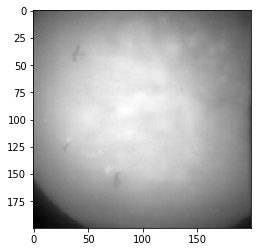

In [21]:
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

In [22]:
test_map = feature_maps(Autoencoder, 'conv2d_2', test_img)

Shape of feature maps: (1, 100, 100, 64)


In [23]:
def plot_feature_maps(inps, row_num, col_num, figsize):
    '''
    This function can only plot the feature maps of a model
    :param inps: feature maps
    :param row_num: number of rows for the plot
    :param col_num: number of columns for the plot

    :return:
        grid plot of size (row_num * col_num)
    '''
    assert inps.ndim == 4, "Input tensor dimension not equal to 4!"

    print("Number of feature maps in layer: ", inps.shape[-1])

    fig, axes = plt.subplots(row_num, col_num, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i, ax in enumerate(axes.flat):
        img = inps[0, :, :, i]

        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()

Number of feature maps in layer:  64


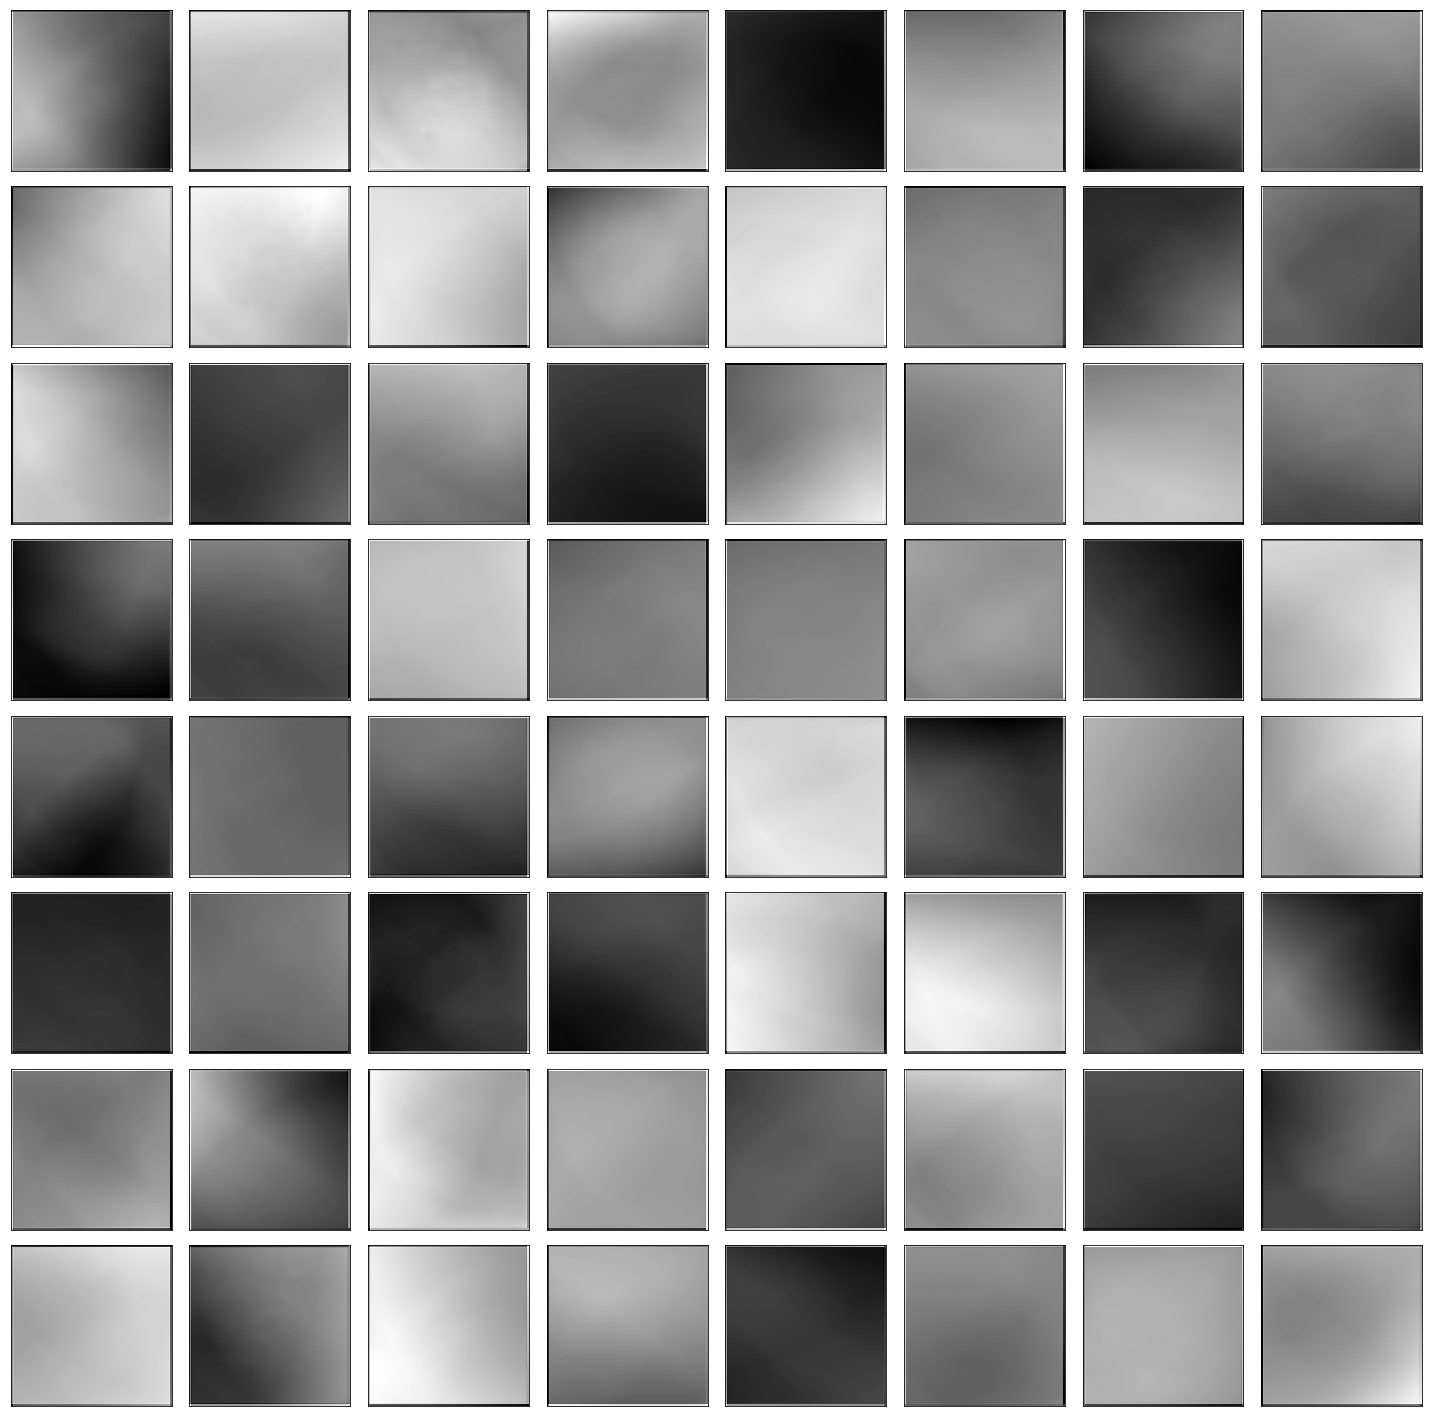

In [24]:
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

Shape of feature maps: (1, 200, 200, 32)
Number of feature maps in layer:  32


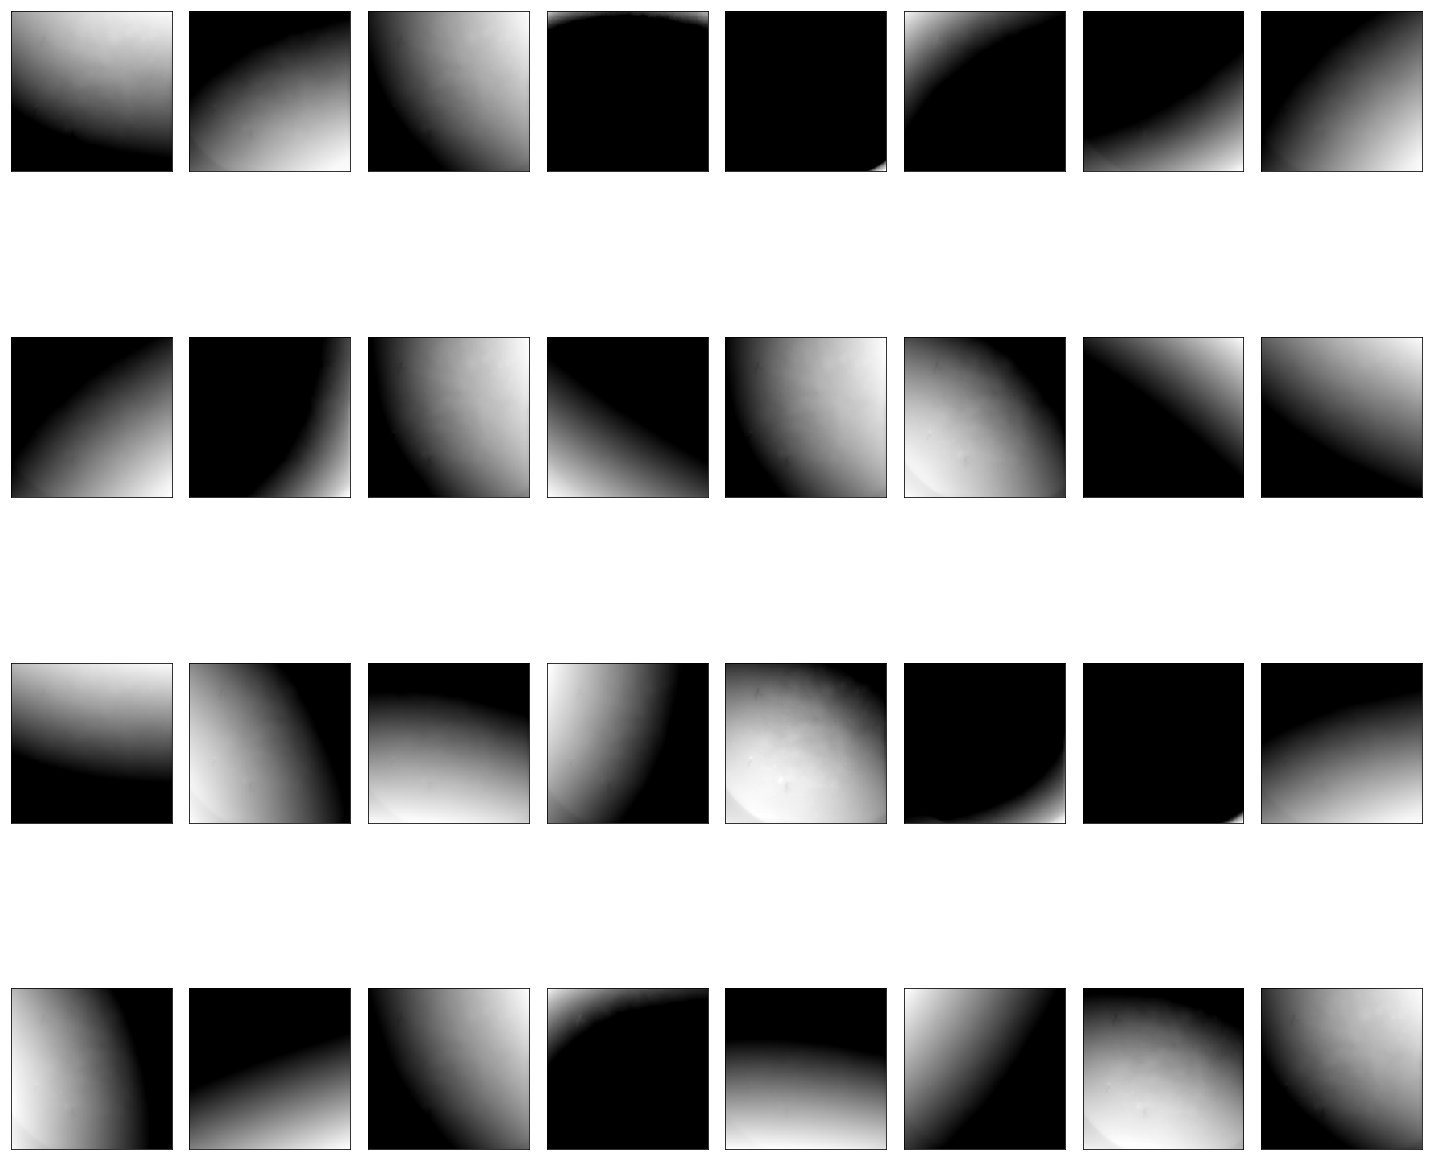

In [25]:
test_map02 = feature_maps(Autoencoder, 'coord_conv', test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

In [26]:
Autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
coord_conv (CoordConv)       (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 48)      13872     
_________________________________________________________________
batch_normalization_v2 (Batc (None, 200, 200, 48)      192       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      27712 